In [1]:
from enum import Enum
from langchain_core.prompts import PromptTemplate


consequences_prompt = """
You are a well informed visionary and entrepreneur with experience in business and economics.

Your job is to predict the consequences of: {event}

Express each consequence as JSON with the following keys:
// be specific
consequence: string
// between 0 and 1
probability: number
"""

consequences_template = PromptTemplate.from_template(consequences_prompt)

second_consequences_prompt = """
For the given event and the given first-order consequence, provide a list of second order consequences.

Original Event: {event}
First-order Consequence: {consequence} 

Other known consequences NOT to include:
---
{known_consequences}
---

For second-order consequences, focus specifically on the consequences of the first-order consequence ONLY. Do not generate other first-order consequences of the event itself that are not direct consequences of the first-order consequence.
Do not include known consequences.
"""
second_consequences_template = PromptTemplate.from_template(second_consequences_prompt)


class Prompts(Enum):
    consequences = "consequences"
    second_consequences = "second_consequences"


class PromptManager:
    @staticmethod
    def get_prompt_template(name: Prompts) -> PromptTemplate:
        if name == Prompts.consequences:
            return consequences_template
        elif name == Prompts.second_consequences:
            return second_consequences_template
        else:
            raise ValueError(f"Invalid prompt name: {name}")
        # langfuse_prompt = langfuse.get_prompt(name.value, label="latest")
        # return PromptTemplate.from_template(langfuse_prompt.get_langchain_prompt())



In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
import operator
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke, starting with 0", ge=0)


# model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = ChatOpenAI(model="gpt-4o-mini")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()


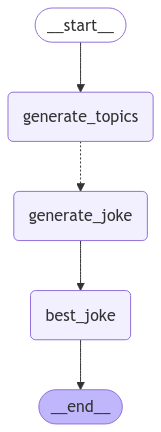

In [7]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [8]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['lion', 'elephant', 'dolphin', 'giraffe', 'penguin']}}
{'generate_joke': {'jokes': ['Why did the lion eat the tightrope walker? Because he wanted a well-balanced meal!']}}
{'generate_joke': {'jokes': ["Why don't giraffes use the internet? Because they can't reach the server!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ['Why did the dolphin bring a towel to the party? Because it wanted to have a whale of a time!']}}
{'generate_joke': {'jokes': ["Why don't penguins like talking to strangers at parties? Because they find it hard to break the ice!"]}}
{'best_joke': {'best_selected_joke': 'Why did the dolphin bring a towel to the party? Because it wanted to have a whale of a time!'}}


In [25]:
import operator
from typing import Annotated, cast
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic

from langgraph.types import Send
from langgraph.graph import END, StateGraph, START

from pydantic import BaseModel, Field

class Consequence(BaseModel):
    consequence: str = Field(description="Specific consequence")
    probability: float = Field(description="Probability between 0 and 1")
    reasoning: str = Field(description="A brief outline of the reasoning behind the consequence and its probability")


class Consequences(BaseModel):
    consequences: list[Consequence] = Field(description="List of consequences and their probabilities")


class SecondConsequences(TypedDict):
    event: str
    consequence: str
    second_consequences: list[Consequence]

model = ChatOpenAI(model="gpt-4o-mini")

class OverallState(TypedDict):
    event: str
    first_consequences: list[Consequence]
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    second_consequences: Annotated[list[SecondConsequences], operator.add]

    aggregated_consequences: list[SecondConsequences]

class SecondConsequenceState(TypedDict):
    event: str
    consequence: str
    known_consequences: list[str]


# This is the function we will use to generate the subjects of the jokes
def generate_consequences(state: OverallState):
    # print(state)
    prompt = consequences_prompt.format(event=state["event"])
    # print(prompt)
    response = model.with_structured_output(Consequences).invoke(prompt)
    consequences = cast(Consequences, response)
    # print(consequences)
    return {"first_consequences": consequences.consequences}

def generate_second_consequences(state: SecondConsequenceState):
    prompt = second_consequences_prompt.format(
        event=state["event"],
        consequence=state["consequence"],
        known_consequences=state["known_consequences"],
    )
    response = model.with_structured_output(Consequences).invoke(prompt)
    consequences = cast(Consequences, response)
    return {"second_consequences": [consequences.consequences]}



def to_second_consequences(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node

    first_consequences = state["first_consequences"]
    def other_consequences(consequence: str):
        return ", ".join(
            [c.consequence for c in first_consequences if c.consequence != consequence]
        )
    second_consequence_data: list[SecondConsequenceState] = [{"event": state["event"], "consequence": c.consequence, "known_consequences": other_consequences(c.consequence)} for c in first_consequences]
    return [Send("generate_second_consequences", x) for x in second_consequence_data]

def aggregate_consequences(state: OverallState):
    
    second_consequences = state["second_consequences"]
    
    return {"aggregated_consequences": second_consequences}


graph = StateGraph(OverallState)

graph.add_node("generate_consequences", generate_consequences)
graph.add_node("generate_second_consequences", generate_second_consequences)
graph.add_node("aggregate_consequences", aggregate_consequences)

graph.add_edge(START, "generate_consequences")
graph.add_conditional_edges("generate_consequences", to_second_consequences, ["generate_second_consequences"])
graph.add_edge("generate_second_consequences", "aggregate_consequences")
graph.add_edge("aggregate_consequences", END)


app = graph.compile()

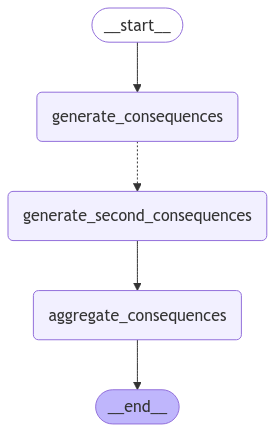

In [26]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [ ]:
import os
from langfuse.callback import CallbackHandler


LANGFUSE_PUBLIC_KEY = os.getenv("LANGFUSE_PUBLIC_KEY")
LANGFUSE_SECRET_KEY = os.getenv("LANGFUSE_SECRET_KEY")
LANGFUSE_HOST = os.getenv("LANGFUSE_HOST")


langfuse_handler = CallbackHandler(public_key=LANGFUSE_PUBLIC_KEY, secret_key=LANGFUSE_SECRET_KEY, host=LANGFUSE_HOST)

# Call the graph: here we call it to generate a list of consequences
for s in app.stream({"event": "LLM technology makes professionals in many industries far more productive."}, config={"callbacks": [langfuse_handler]}):
    print(s)



{'generate_consequences': {'first_consequences': [Consequence(consequence='Increased security measures for CEOs and high-profile executives in NYC and nationwide', probability=0.9, reasoning='The assassination of a major CEO would prompt companies and governments to enhance security protocols to protect other executives.'), Consequence(consequence='Heightened public fear and anxiety regarding corporate leadership and safety', probability=0.85, reasoning='Such a violent act would cause widespread concern among the public about the safety of corporate leaders and potential instability in the business environment.'), Consequence(consequence='Stock market volatility, particularly in health care and related sectors', probability=0.8, reasoning='Investors may react negatively to the uncertainty created by the assassination, leading to fluctuations in stock prices.'), Consequence(consequence='Increased scrutiny and regulation of the health care industry', probability=0.7, reasoning='The assas